<a href="https://colab.research.google.com/github/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/blob/colabs/Notebooks/1_NO2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías y datos 

En esta notebook vamos a interactuar con la plataforma de Google Earth Engine (GEE). Para esto es necesario tener una cuenta en gmail.

Por un lado vamos a aprender a bajar los datos brutos. Igualmente tenemos procesados en un git los datos para ganar tiempo.

In [ ]:
import ee
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=kcBC8PzjMXqgdZFL8CaqlnWodAJEts_ADJPHTqZ7JCc&tc=ARTO4r5vaA69ebabv5zCPEiYwX0EnED_GrGQIMrV2D4&cc=4KdksBQLVZHS8g110r_0ic2wa0kl-Vj-j0IAbfXEVfo

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgxEYnxpBrO9DGRMoNV0j2Hei2SCQIevvm-W9YC4B-x44BVB0ez8GI

Successfully saved authorization token.


Importamos librerías de python que nos van a ser útiles

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib as mpl
import matplotlib.ticker



In [ ]:
## Descarga del repositorio ##
!git clone https://github.com/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos.git

Cloning into 'Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 85 (delta 22), reused 74 (delta 14), pack-reused 0
Unpacking objects: 100% (85/85), done.
Archive:  Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Modelos/Modelo_vehiculos.zip
  inflating: Modelo_vehiculos.json   


El objetivo es poder descargar para una determinada región de interés, una serie temporal de  NO$_2$ (o podría ser otro gas) del satélite Sentinel 5p.

En el siguiente link (https://developers.google.com/earth-engine/datasets/) está todo el catálogo de datos disponible de la plataforma.


Primero definamos una región de interés. Este va a ser un rectángulo de latitud longitud. Podría ser un polígono de puntos también. Por ejemplo nuestro caso de estudio va a ser la ciudad de buenos aires

In [ ]:
ciudad = 'Buenos Aires'

lat_n=-34.52
lat_s=-34.73
lon_w=-58.56
lon_e=-58.33 

delta=0    ## este parámetro es solo para agrandar o achicar la region de manera proporcional.



Veamos qué región es esta, para eso usemos la librería Cartopy. Les dejamos una notebook muy buena introductoria a la librería: https://colab.research.google.com/github/astg606/py_materials/blob/master/visualization/introduction_cartopy.ipynb#scrollTo=DbmFDgM9MNVO

El parámetro delta es simplemente para achicar o agrandar el rectángulo sin tener que estar buscando en un mapa las coordenadas cada vez.


In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (85.1 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

Esta librería no tiene cargados mapas con divisiones políticas menores a provincias. Por lo tanto usamos un _basemap_ externo que lo descargamos del git de la clase.

Hacemos un gráfico de la región de interés.

/usr/local/lib/python3.7/dist-packages/cartopy/mpl/geoaxes.py:800: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fba749d6f50> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


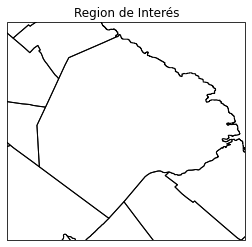

In [ ]:
#from cartopy.io.shapereader import Reader
data = shapereader.Reader('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Mapas/Argentina/gadm36_ARG_2.shp')
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_geometries(data.geometries(), crs=ccrs.Geodetic(), edgecolor='k', facecolor='none')
ax.set_extent([lon_w, lon_e, lat_s, lat_n])
ax.set_title("Region de Interés")
plt.show()

##Descarga directa de GEE

###Series temporales

####Geometrías

Primero hay que determinar la región de donde vamos a descargar los datos. GEE maneja los datos con un objeto que se llama _Geometry_.

Para nuestro caso de estudio vamos a tomar un rectánulo de latitud-longitud.

In [ ]:
roi = ee.Geometry.Rectangle([np.round(lon_w-delta,2), np.round(lat_s-delta,2), np.round(lon_e+delta,2), np.round(lat_n+delta,2)],geodesic= False,proj='EPSG:4326')


En vez de un rectánculo se puede dar una tira de puntos de latitud y longitud. La sintáxis para un polígono es:



```
roi=ee.Geometry.Polygon([x0,y0,x1,y1,...,xn,yn])
```

Donde el par $(x_i,y_i)$ es el par longitud-latitud del punto $i$. El último punto no tiene que ser necesariamente el mismo que el inicial, GEE entiende que el polígono siempre está cerrado. Se puede trabajar con puntos, con circulos centrados en un punto, anillos. Para más opciones pueden ver en https://developers.google.com/earth-engine/guides/geometries. 

Tengan en cuenta que en la plataforma de GEE el código está en javascript. Sin embargo todas las funciones de GEE tienen una sintaxis similar en Python.


Dentro de ese rectángulo hay muchísimos píxeles (la información provista por GEE tiene una resolución de 0.01° x 0.01°). Sin embargo la salida final va a ser un único valor para todo esa región. Es por eso que se necesita una función de reducción que lo que hace es reducir la información. Este método puede ser simplemente calculando el promedio de todos los píxeles que caen dentro del polígono. Aunque nos podría interesar la mediana, o los valores mínimos y máximos dentro de la región de interes, entre otras. 

Por otro lado necesitamos una función auxiliar que interactúe con GEE y Python y nos devuelva la información en un formato un poco más amable (para aquelles que no manejamos javascript)

Para más info pueden entrar a: https://developers.google.com/earth-engine/tutorials/community/time-series-visualization-with-altair?hl=sr

####Función de reducción 

La función *create_reduce_region_function* crea la función de reducción de región donde se van a reducir los pixeles de una colección de imágenes a un único valor dada alguna medida estadística (media, mediana, máximo). Sus parámetros son :

*   La región  de interés (_ee.Geometry_) 
*   El método de reducción  (_ee.Reducer_) que es el método por medio del cual se reducirá la información (media por ejemplo). 
*   La escala del píxel en metros.
*   La proyección  _crs_.
*   Parámetros que no le vamos a dar tanta importancia: _bestEffort_ que es un indicador booleano para saber si se debe utilizar una escala mayor si la geometría  ingresada contiene demasiados píxeles a la escala dada para que la reducción tenga éxito. _maxPixels_ es el número máximo de píxeles a reducir y _tileScale_ es un factor de scala usado para evitar que el cálculo del reductor se quede sin memoria. Si la cuenta converge, no influye en el resultado más que en redondeos de punto flotante. 

Luego de seleccionar la colección de imágenes por medio de *ee.ImageCollection* y filtrarla por variable y por fecha, se procede a utilizar el comando *ee.FeatureCollection* que toma como input la función de reducción que calculamos.

Una imagen que funciona como esquema de lo que estamos intentando realizar:

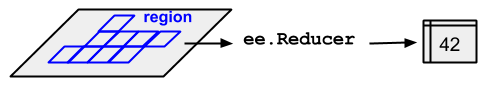

In [ ]:
#######Esta función es la que interactura con la api de GEE y general e método de reducción######
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):

  def reduce_region_function(img):

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function



Dijimos que el resultado de aplicar la función de reducción sobre la colección de imagenes genera un *ee.FeatureCollection*. La función *fc_to_dict_* toma esa tabla y la transfiere al kernel de Python transformándolo en un diccionario. Por último con *add_date_info* transformamos en data frame de pandas y agregamos alguna información extra que nos va a ser más útil después. 


In [ ]:
####Estas funciones transforman en diccionarios y luego en data frames la info reducida###

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
  df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
  return df

####Descarga

Bueno ya estamos listes para descargar nuestros datos.

In [ ]:
inicio='2018-07-01'
final ='2020-12-01'
    
coleccion = 'COPERNICUS/S5P/OFFL/L3_NO2'
variable  = 'tropospheric_NO2_column_number_density'
var_name  = 'NO2_trop_mean'
file_name = ciudad+'_NO2trop.csv'

reduce_mean = create_reduce_region_function(geometry=roi, reducer=ee.Reducer.mean(), scale=1113.2, crs='EPSG:4326')
reduce_std  = create_reduce_region_function(geometry=roi, reducer=ee.Reducer.sampleStdDev(), scale=1113.2, crs='EPSG:4326')

gas_trop=ee.ImageCollection(coleccion).select(variable).filterDate(inicio,final)
gas_trop_mean_fc = ee.FeatureCollection(gas_trop.map(reduce_mean)).filter(
    ee.Filter.notNull(gas_trop.first().bandNames()))
gas_trop_std_fc = ee.FeatureCollection(gas_trop.map(reduce_std)).filter(
    ee.Filter.notNull(gas_trop.first().bandNames()))

gas_trop_mean_dict=fc_to_dict(gas_trop_mean_fc).getInfo()
gas_trop_std_dict=fc_to_dict(gas_trop_std_fc).getInfo()

gas_trop_mean_df=pd.DataFrame(gas_trop_mean_dict)
gas_trop_std_df=pd.DataFrame(gas_trop_std_dict)

gas_trop_mean_df =  add_date_info(gas_trop_mean_df)
gas_trop_mean_df  = gas_trop_mean_df.rename(columns={variable: var_name}).drop(columns=['millis', 'system:index'])
gas_trop_mean_df['NO2_trop_std']=gas_trop_std_df[variable]

gas_trop_mean_df.to_csv(file_name,index=True)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####Pre-procesamiento de las ST

Sentinel es un sátelite de órbita polar, por lo que hay una observación por día, o a veces por solapamiento del camino del satélite hay dos (y para latitudes bajas puede haber alguna región no observada!). Por otro lado, el sensor Tropomi es sensible a la cobertura nubosa. La medición puede verse afectada y debido al control de calidad hecho por GEE, hay observaciones que son descartadas. 

Para el TP, reducimos las observaciones diarias a una por día tomando el promedio de todos los pixeles. El resultado final es una serie temporal diaria con datos faltantes.

¿Qué tipo de limitaciones contrae esta elección?

Les dejamos el código para realizar las medias diarias, semanales y mensuales. Para ahorrar tiempo y evitar tener que subir al drive de cada uno de ustedes los archivos, ya cargamos las series calculadas. Entre otras cosas, tiramos los datos posteriores al 27 de noviembre e intercalamos explicitamente los datos faltantes para que nos quede una serie de tiempo equiespaciada (solo en el caso diario y en el semanal, porque no hay meses con datos faltantes). También figura cuántos días se utilizaron para hacer las medias semanales y mensuales.



In [ ]:
!pip install isoweek
import isoweek

In [ ]:

import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

 

ciudad='Buenos Aires'
gas='NO2_trop'
columna=gas+'_mean'
columna_std= gas+'_std'
    
 
df=pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/Buenos Aires_NO2trop_crudo.csv')   
df_diario=df.groupby(['Year','Month','Day']).mean().reset_index()
df_diario['Fecha_datetime']=pd.to_datetime(df_diario['Year'].astype(str)+'-'+df_diario['Month'].astype(str)+'-'+df_diario['Day'].astype(str),format='%Y-%m-%d')
df_diario=df_diario[df_diario['Fecha_datetime']<datetime.datetime(2020,11,27)] ### saco los valores posteriores a 27 de nov de 2020 por calibracion
df_diario.drop(columns=['Unnamed: 0','DOY'],inplace=True)

##Relleno con datos faltantes de manera explicita)
t=df_diario.Fecha_datetime.values
dias_completos=pd.date_range(start=t[0], end=t[-1]).to_frame(name='Fecha_datetime')
df_diario=dias_completos.merge(df_diario, how='left',on='Fecha_datetime')
df_diario['Year']=df_diario['Fecha_datetime'].dt.year
df_diario['Month']=df_diario['Fecha_datetime'].dt.month
df_diario['Day']=df_diario['Fecha_datetime'].dt.day


###########Calculo las medias semanales###############################    
df_semanal=df_diario
dia=df_diario.Fecha_datetime.dt.date.values
semanas=[isoweek.Week.withdate(d) for d in dia]
df_semanal['WeekofYear']=semanas
df_semanal_count=df_semanal.groupby(['WeekofYear']).count().reset_index()
df_semanal=df_semanal.groupby(['WeekofYear']).mean().reset_index()
df_semanal['N_days']=df_semanal_count[columna]
lunes=[isoweek.Week.monday(s) for s in df_semanal.WeekofYear.values]
df_semanal['Fecha_datetime']=lunes
df_semanal.drop(columns=['Year','Month','Day'],inplace=True) 


###########Calculo las medias mensuales ######################################    
df_mensual=df_diario.groupby(['Year','Month']).mean().reset_index()
df_mensual_c=df_diario.groupby(['Year','Month']).count().reset_index()
df_mensual['Fecha_datetime']=pd.to_datetime(df_mensual['Year'].astype(str)+'-'+df_mensual['Month'].astype(str),format='%Y-%m')
df_mensual.drop(columns=['Day'],inplace=True)
df_mensual['N_days']=df_mensual_c[columna]


df_diario.to_csv(ciudad+'_NO2trop_diario.csv',index=False)
df_semanal.to_csv(ciudad+'_NO2trop_semanal.csv',index=False)
df_mensual.to_csv(ciudad+'_NO2trop_mensual.csv',index=False)

files.download(ciudad+'_NO2trop_diario.csv')
files.download(ciudad+'_NO2trop_semanal.csv')
files.download(ciudad+'_NO2trop_mensual.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Análisis de las ST

Analicemos la serie temporal de NO$_2$ de julio 2018 a diciembre 2021 sobre la ciudad de Buenos Aires. Hubo una actualización en diciembre 2020 en la forma en la que Copernicus preprocesa las observaciones del TROPOMI  de  NO$_2$ y eso generó un salto espurio positivo en las observaciones. Al momento se recalibraron las observaciones hasta el 14 de noviembre del 2021 pero éstas aún no están disponibles en la plataforma GEE.

In [ ]:
df   = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/Buenos Aires_NO2trop_diario.csv')
df_w = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/Buenos Aires_NO2trop_semanal.csv')
df_m = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/Buenos Aires_NO2trop_mensual.csv')

df

,Fecha_datetime,Year,Month,Day,NO2_trop_mean,NO2_trop_std,WeekofYear
0,2018-07-08,2018,7,8,0.000051,0.000025,2018W27
1,2018-07-09,2018,7,9,NaN,NaN,2018W28
2,2018-07-10,2018,7,10,NaN,NaN,2018W28
3,2018-07-11,2018,7,11,0.000095,0.000010,2018W28
4,2018-07-12,2018,7,12,0.000157,0.000016,2018W28
...,...,...,...,...,...,...,...
868,2020-11-22,2020,11,22,0.000049,0.000022,2020W47
869,2020-11-23,2020,11,23,0.000060,0.000026,2020W48
870,2020-11-24,2020,11,24,NaN,NaN,2020W48
871,2020-11-25,2020,11,25,0.000081,0.000033,2020W48


In [ ]:
df['Fecha_datetime']=pd.to_datetime(df['Fecha_datetime'].astype(str),format='%Y-%m-%d')  ##esto transforma el formato de la fecha de string a datetime

Vamos a trabajar entonces con la serie. Primero visualicémosla. Variemos la ventana temporal de datos para observar posibles patrones modificando los objetos "inicio" y "fin" siempre respetando el formato 'YYYY-MM-DD'. 

No handles with labels found to put in legend.


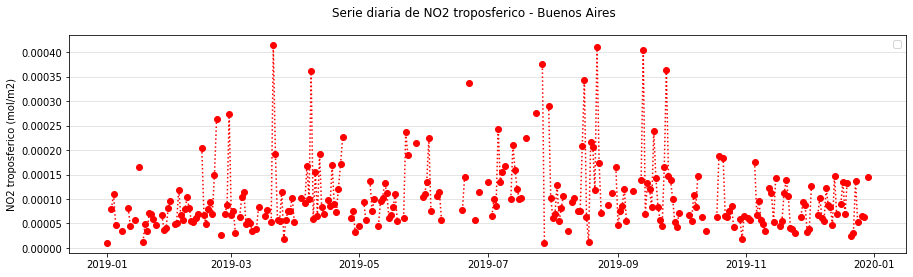

In [ ]:
inicio='2019-01-01'
fin   ='2020-01-01'

########################no tocar ###############
import datetime
columna='NO2_trop_mean'
gasname = 'NO2 troposferico'

figsize=(15,4)
rango=np.logical_and(df['Fecha_datetime']>= inicio,df['Fecha_datetime']<=fin)
da=df[rango]
plt.figure(figsize=figsize)
plt.plot(da.Fecha_datetime,da[columna],'ro:')
plt.suptitle('Serie diaria de '+gasname+ ' - '+ciudad)
plt.grid(axis='y',alpha=0.4)
plt.ylabel(gasname+ ' (mol/m2)')
plt.legend()

###Por si quieren descargar la imagen
#plt.savefig(ciudad +'seriediaria.png',bbox_inches='tight',dpi=500)
#files.download(ciudad +'seriediaria.png')

A priori la serie parece bastante ruidosa. Hay varios métodos para ver qué tipo de dinámica interna tiene una serie temporal. Particularmente estamos trabajando con una serie bastante corta y con mucho dato faltante. Una forma de ver qué tipo de ciclos posee una serie es hacer un autocorrelograma. Sin embargo hay que tener cuidado con los datos faltantes. Los autocorrelogramas (y muchos análisis estadísticos sobre series temporales) necesitan que la serie sea temporalmente equiespaciada.

*   Con los datos obtenidos de Sentinel, ¿se cumple esa exigencia?
*   ¿Qué podríamos hacer con los datos faltantes?

Si bien en la tabla de datos bajada no figuran los faltantes, viendo las fechas se puede observar que hay días que no figuran. Los agregamos de manera explícita.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  app.launch_new_instance()


Text(0.5, 1.0, 'Autocorrelograma de la serie diaria')

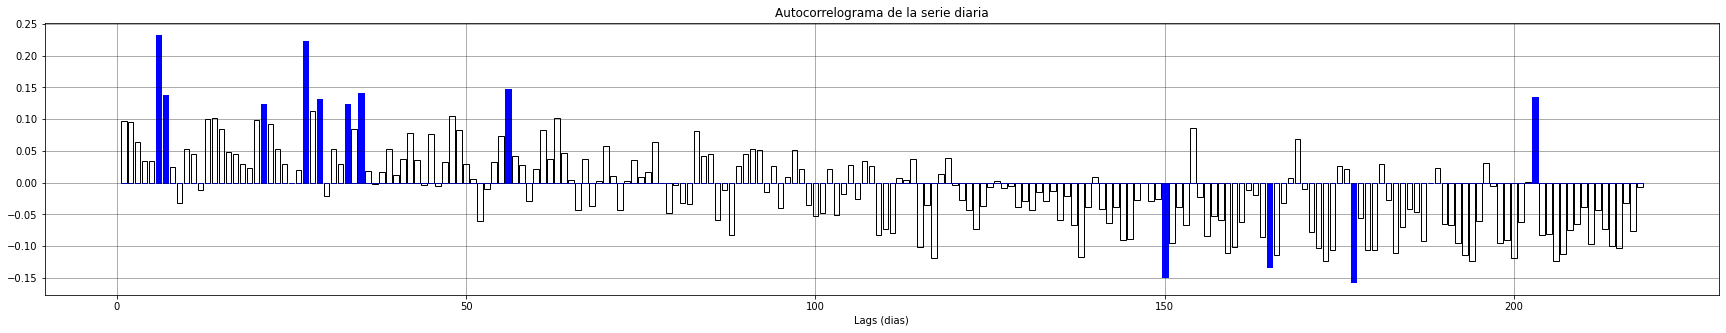

In [ ]:
############# parametros para tocar#########3
N= len(df[columna])       
lags = N//4
pvalor =0.01

###############no tocar ############
from scipy.stats import pearsonr

df_autocor=df[['Fecha_datetime','NO2_trop_mean']]
color_significativo = 'blue'
color_no_sig = 'white'
figsize=(30,5)
titulo = 'Autocorrelograma de la serie diaria'

for i in range(lags+1):
    df_autocor['lag_'+str(i)]=df_autocor[columna].shift(i)

rho=[]
pval=[]
for i in range(lags+1):
    lagfila='lag_'+str(i)
    columnas=[columna,lagfila]
    a=df_autocor[columnas]
    b=a.dropna()._get_numeric_data()
    rho.append(pearsonr(b[columna], b[lagfila])[0])
    pval.append(pearsonr(b[columna], b[lagfila])[1])

rhoenmascarado=np.copy(rho)

for i in range(len(pval)):
    if pval[i]>pvalor:
        rhoenmascarado[i]=0

plt.figure(figsize=figsize)
plt.bar(np.arange(1,lags+1),rho[1:],color=color_no_sig,edgecolor='black')
plt.bar(np.arange(1,lags+1),rhoenmascarado[1:],color=color_significativo,edgecolor=color_significativo)
plt.grid(color='black',alpha=0.4)
plt.xlabel('Lags (dias)')
plt.title(titulo)

###Por si quieren descargar la imagen
#plt.savefig(ciudad +'acf.png',bbox_inches='tight',dpi=500)
#files.download(ciudad +'acf.png')

Hicimos el código del autocorrelograma a mano, porque Colab tiene una versión de Python más vieja, y el paquete *statsmodels* que hace autocorrelogramas con datos faltantes necesita una versión de Python más nueva. Les dejamos el código para que lo corran en sus notebooks (que esperamos tengan un python 3.8). 


```
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(df_autocor[columna], lags=400,missing='conservative')
plt.show()
```



Si corren la celda en el colab les va a decir que esta función no tiene un parámetro "missing" (el que trata los datos faltantes) porque en esta versión del *acf* del paquete *statsmodels* no tiene esa opción. 
En el gráfico anterior se ven en negro las correlaciones significativas. Se ve que hay un pico entre los 6 y 7 días, otro en los 27 y 28. (7 y 28 son múltiplos, luego aparece el 35 y más adelante en los 56). Es decir que la serie correlaciona muy bien consigo misma si se desfasa entre 6 y 7 días o en múltiplos enteros. Eso significa que la serie temporal tiene un patron semanal.

*   En meteorología ¿qué patrones estacionales usuales esperarían ver? 

*   Si la serie meteorológica fuese de resolución horaria ¿en qué $\Delta t$ observarían picos de correlación significativa?

*   ¿Hay algun fenómeno natural que sea semanal? ¿que diferencie días de semana de fines de semana?

*   ¿Qué pasa con los casos de COVID? El virus no diferencia lunes de domingos,  sin embargo hay menos registro de casos los fines de semana. La forma de medición impone un sesgo a los datos.  

*   Este gráfico muestra que este gas tiene un fuerte comportamiento asociado a la actividad humana (que sí diferencia lunes de domingos) ¿qué podríamos concluir con esta observación?


Para ver otro tipo de variabilidad interna más alla de la semanal tenemos varios métodos. Reducción de resolución tomando medias semanales, promedios móviles con una ventana de 7 días, o podríamos realizar un análisis armónico y filtrar la onda de 7 días.

Por otro lado podemos hacer lo mismo pero tomando medias mensuales. Esta última nos va a servir para hacer comparaciones interanuales. El NO$_2$ posee una variabilidad estacional, como discutimos en la teórica. Entonces tiene sentido comparar el abril 2020 con abril 2019.


No handles with labels found to put in legend.


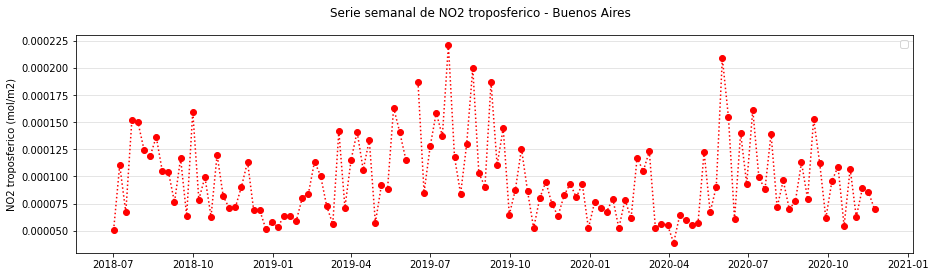

In [ ]:
df_w['Fecha_datetime']=pd.to_datetime(df_w['Fecha_datetime'].astype(str),format='%Y-%m-%d')


figsize=(15,4)
plt.figure(figsize=figsize)
plt.plot(df_w.Fecha_datetime,df_w[columna],'ro:')
plt.suptitle('Serie semanal de '+gasname+ ' - '+ciudad)
plt.grid(axis='y',alpha=0.4)
plt.ylabel(gasname+ ' (mol/m2)')
plt.legend()

###Por si quieren descargar la imagen
#plt.savefig(ciudad +'seriesemanal.png',bbox_inches='tight',dpi=500)
#files.download(ciudad +'seriesemanal.png')

En el gráfico de medias semanales pareciera más evidente ahora que hay un ciclo anual. Se pueden ver mínimos en los veranos y máximos en los inviernos. Esto es consistente con la biliografía.

¿Qué pasa si hacemos un autocorrelograma con esa serie?

Text(0.5, 1.0, 'Autocorrelograma de la serie diaria')

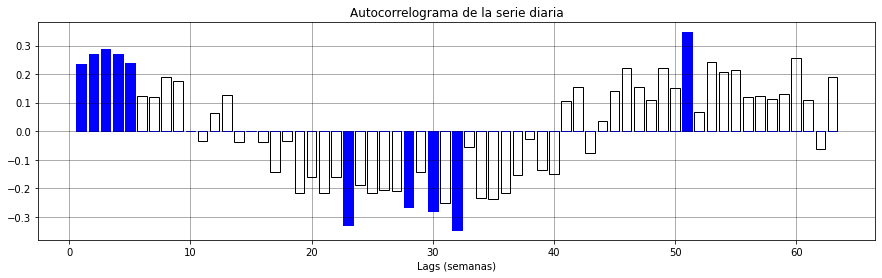

In [ ]:
############# parametros para tocar#########3
N= len(df_w[columna]) #cantidad de datos

lags = N//2
pvalor =0.01

###############no tocar ############
color_significativo = 'blue'
color_no_sig = 'white'
figsize=(15,4)
titulo = 'Autocorrelograma de la serie semanal'

from scipy.stats import pearsonr

df_autocorr_w=df_w
for i in range(lags+1):
    df_autocorr_w['lag_'+str(i)]=df_autocorr_w[columna].shift(i)

rho=[]
pval=[]
for i in range(lags+1):
    lagfila='lag_'+str(i)
    columnas=[columna ,lagfila]
    a=df_autocorr_w[columnas]
    b=a.dropna()._get_numeric_data()
    rho.append(pearsonr(b[columna], b[lagfila])[0])
    pval.append(pearsonr(b[columna], b[lagfila])[1])

rhoenmascarado=np.copy(rho)

for i in range(len(pval)):
    if pval[i]>pvalor:
        rhoenmascarado[i]=0

plt.figure(figsize=figsize)
plt.bar(np.arange(1,lags+1),rho[1:],color=color_no_sig,edgecolor='black')
plt.bar(np.arange(1,lags+1),rhoenmascarado[1:],color=color_significativo,edgecolor=color_significativo)
plt.grid(color='black',alpha=0.4)
plt.xlabel('Lags (semanas)')
plt.title(titulo)

###Por si quieren descargar la imagen
#plt.savefig(ciudad +'acfsemanal.png',bbox_inches='tight',dpi=500)
#files.download(ciudad +'acfsemanal.png')

Mirando el gráfico observamos que hay una onda, en contrafase cerca de las 20 y 30 semanas y luego un máximo cerca de las 50. Sin embargo rápidamente cae la significancia estadística porque dividimos por siete la cantidad de datos total (pasamos de siete datos por semana a uno solo). Ya la serie diaria no era muy larga, por lo que la de medias semanales es aun más corta. Esto no quita que no exista una correlación anual, porque ya la habíamos visto en el autocorrelograma diario.

Podríamos repetir lo mismo con la serie mensual, pero el autocorrelograma sería aun más inútil. Sin embargo para observar variaciones interanuales, de manera más descriptiva, sirve.

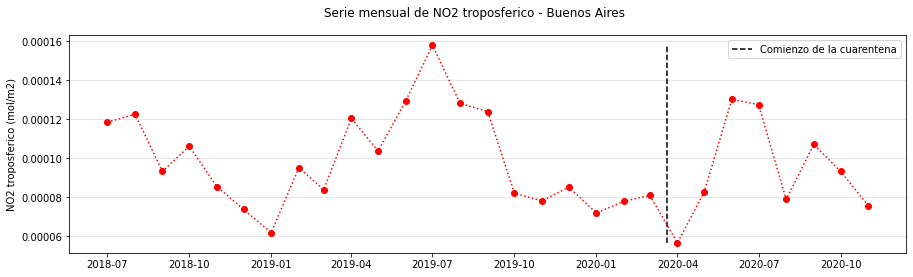

In [ ]:
df_m['Fecha_datetime']=pd.to_datetime(df_m['Fecha_datetime'].astype(str),format='%Y-%m-%d')

CC=df_m[columna].values
plt.figure(figsize=(15,4))
plt.plot(df_m.Fecha_datetime,df_m[columna],'ro:')
plt.suptitle('Serie mensual de '+gasname+ ' - '+ciudad)
plt.grid(axis='y',alpha=0.4)
plt.ylabel(gasname+ ' (mol/m2)')
cuarentena=datetime.datetime.strptime('20200320', '%Y%m%d')
plt.vlines(cuarentena,ymin=np.min(CC),ymax=np.max(CC),colors='black',linestyle='dashed',label='Comienzo de la cuarentena')
plt.legend() 

###Por si quieren descargar la imagen
#plt.savefig(ciudad +'seriemensual.png',bbox_inches='tight',dpi=500)
#files.download(ciudad +'seriemensual.png')

En la figura anterior podemos ver mucho más claro el impacto de la cuarentena en la media mensual. No solo el valor medio de abril 2020 es un mínimo absoluto en el período (mes donde las restricciones fueron mucho más intensas y respetadas), sino incluso en los máximos de invierno, la emisión de NO$_2$ fue menor que el año anterior.

Podemos hacer una comparación más clara ente 2019 y 2020 con un gráfico de barras.

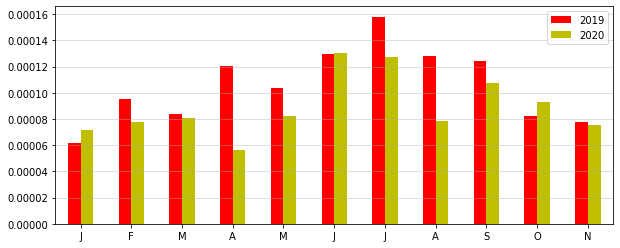

In [ ]:
no2_2019=df_m[df_m.Year==2019][columna].values
no2_2020=df_m[df_m.Year==2020][columna].values
mes=['J','F','M','A','M','J','J','A','S','O','N']
df_bar = pd.DataFrame({'2019': no2_2019[:-1],
                    '2020': no2_2020}, index=mes)

ax = df_bar.plot.bar(rot=0,color=['r','y'],figsize=(10,4))
plt.grid(axis='y',alpha=0.5)

###Por si quieren descargar la imagen
#plt.savefig(ciudad +'seriecomparada.png',bbox_inches='tight',dpi=500)
#files.download(ciudad +'seriecomparada.png')

Podríamos estimar una caída porcentual en abril:

$\Delta [NO_2]=100\times\frac{[NO_2](abril_{2020})-[NO_2](abril_{2019})}{[NO_2](abril_{2019})}$

In [ ]:
print('La variación interanual para abril 2020-2019 es:',np.round(100*(no2_2020[3]-no2_2019[3])/no2_2019[3],2),'%')

La variación interanual para abril 2020-2019 es: -53.14 %


##Distribución espacial del NO2: comparación interanual

Si bien el objetivo de la actividad es analizar una serie temporal, tomando un único valor para toda una región, también está bueno analizar qué pasa con la variabilidad espacial de las emisiones (reduciendo en este caso, la dimensión temporal, por ejemplo tomando una media mensual o lo que se les ocurra).
En este pequeño apartado tienen una rutina para obtener una matriz de emisión de no2 por pixel, con su correspondiente latitud longitud. Esta matriz es un array de numpy, que puede ser insumo para un modelo por ejemplo. 

In [ ]:
##Este código es para tener una visualización espacial del no2. Vamos a tomar medias mensuales

##Esto lo pueden modificar a gusto##

inicio='2019-04-01'
final ='2019-05-01' #la fecha final que sea 1 mes despues, así calcula la media mensual

inicio2='2020-04-01'   ###que este mes sea el mismo, pero un año diferente, asi hacemos una comparacion interanual
final2 ='2020-05-01'


####De acá en adelante traten de no tocar nada a menos que tengan claro####

collection=ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate(inicio,final)
collection2=ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2').select('tropospheric_NO2_column_number_density').filterDate(inicio2,final2)

###si quisiéramos otra cosa que no sea la media, hay que cambiar el parámetro .mean()

collection_img=collection.mean().setDefaultProjection(collection.first().projection())
collection_img2=collection2.mean().setDefaultProjection(collection2.first().projection())

####para 2019####

##Este codigo es un poco un lío pero básicamente lo que hace, una vez obtenida la imagen de GEE
##en una determinada region de interes (roi),transforma en un array de numpy y tambien
##obtiene las matrices de lat y lon, el tema es que hay que reshapear porque viene todo en una tira de datos. 

latlon=ee.Image.pixelLonLat().addBands(collection_img)
latlon_new = latlon.reduceRegion(reducer=ee.Reducer.toList(), geometry=roi, maxPixels=1e13,scale=1113.2)

no2 = np.array((ee.Array(latlon_new.get('tropospheric_NO2_column_number_density')).getInfo()))
lats = np.array((ee.Array(latlon_new.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon_new.get("longitude")).getInfo()))  ##Prueben hacer lons.shape y y van a ver que es un horror.

##reshape para que quede tres matrices tipo meshgrid
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
ncols = len(uniqueLons)    
nrows = len(uniqueLats)

no2_2019=no2.reshape(nrows,ncols)
LATS=lats.reshape(nrows,ncols)
LONS=lons.reshape(nrows,ncols)

###repetimos para 2020###

##Podríamos hacer lo mismo, pero las matrices de lat y lon son  iguales. Una forma más corta
##que permite obtener el array de los valores (pero que no nos da la lat y lon) es la funcion
##ee.Image.sampleRectangle. Ya viene con las dimensiones correctas y no hay que reshapear

no2_2020=np.array(collection_img2.sampleRectangle(roi).get('tropospheric_NO2_column_number_density').getInfo())

##para tomar una unica escala de colores tomo el valor maximo de ambos arrays
vmax=np.max([np.max(no2_2020),np.max(no2_2019)])

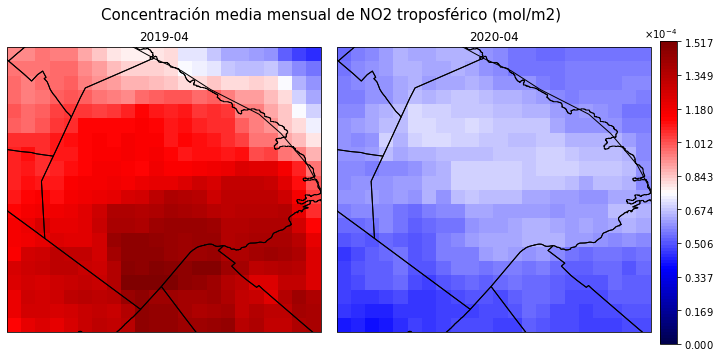

In [ ]:
###Esta es la rutina de graficado. No rompan nada###

##colores
cmap=mpl.cm.get_cmap('seismic',100)  


fig, axs = plt.subplots(nrows=1,ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,6))
fig.subplots_adjust(top=0.89,right=0.87,wspace=0.05, hspace=0.07)

plt.suptitle('Concentración media mensual de NO2 troposférico (mol/m2)',fontsize=15,y=0.93)

cs=axs[0].pcolormesh(LONS,LATS,no2_2019,vmin=0,vmax=vmax, cmap=cmap)
axs[0].add_feature(cartopy.feature.COASTLINE)
axs[0].add_feature(cartopy.feature.BORDERS)
axs[0].add_geometries(data.geometries(), crs=ccrs.Geodetic(), edgecolor='k', facecolor='none')
axs[0].set_extent([np.min(LONS), np.max(LONS), np.min(LATS), np.max(LATS)])
axs[0].set_title(inicio[:-3])

axs[1].pcolormesh(LONS,LATS,no2_2020,vmin=0,vmax=vmax, cmap=cmap)
axs[1].add_feature(cartopy.feature.COASTLINE)
axs[1].add_feature(cartopy.feature.BORDERS)
axs[1].add_geometries(data.geometries(), crs=ccrs.Geodetic(), edgecolor='k', facecolor='none')
axs[1].set_extent([np.min(LONS), np.max(LONS), np.min(LATS), np.max(LATS)])
axs[1].set_title(inicio2[:-3])

cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
cbar=fig.colorbar(cs, cax=cbar_ax,ticks=np.linspace(0,vmax,10),format=fmt)

###Por si quieren descargar la imagen
#plt.savefig(ciudad +'.png',bbox_inches='tight',dpi=500)
#files.download(ciudad +'.png')